## Hatched map plot showing correlation (Pearson's p and r values) between SM-LG and interpolated freeboard smoothed anomalies for full 2010-2020 period

In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
import numpy.ma as ma
import tqdm
import warnings
warnings.filterwarnings("ignore")

## CS2_CPOM

In [2]:
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

# import snow data
snow = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/SM_snod_combined_regridded.npy')
x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_x_WG.npy') # load Will's grid, 160 x 160 array
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_y_WG.npy')

# import CS2_CPOM data
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/CS2_CPOM/'
all_fbs = np.full((4018,160,160), np.nan)
for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if 'FB_interp' in f:
            if date in f:
                all_fbs[day] = np.load(datapath+str(f)) 
            else: 
                pass
#np.save('/Users/carmennab/PhD/OI_PolarSnow/robbiefreebs.npy', all_fbs)

100%|██████████████████████████████████████| 4018/4018 [00:16<00:00, 247.97it/s]


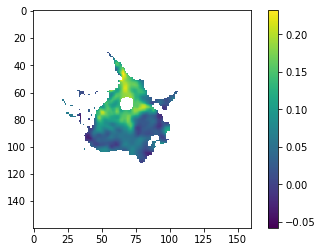

In [3]:
plt.imshow(all_fbs[300])
plt.colorbar()

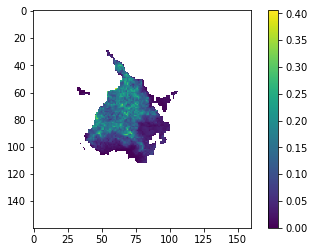

In [4]:
plt.imshow(snow[300])
plt.colorbar()

# plot all seasons in one

In [5]:
# do smooth anoms for each grid cell

T1 = 15 ## for 30-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # each day, make the 30 day running mean (15 either side)
    
    snows_30day = np.nanmean(snow[day-T1:day+T1],axis=0) # 30-day running mean for each grid cell in time dimension
    freeb_30day = np.nanmean(all_fbs[day-T1:day+T1],axis=0)
    
    # now make anomalies from 30 day means
    
    snows_anoms_big[day] = snow[day] - snows_30day 
    freeb_anoms_big[day] = all_fbs[day] - freeb_30day
    

# the following for loop can actually be removed by taking the running mean with convolve
# RDCM has done this before, you have to convolve along an axis of a 3d numpy array using a special module

fb_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)
# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
    
        fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
        sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 4018/4018 [00:04<00:00, 974.48it/s]


In [6]:
ps = np.full((160,160), np.nan)
rs = np.full((160,160), np.nan)
ss = np.full((160,160), np.nan)
n_valid = np.full((160,160), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                              np.arange(160))):
    # calculate p and r for full timeseries per grid cell
    
    mask = ~np.isnan(sd_running_mean_anoms[:,i,j]) & ~np.isnan(fb_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue
        
            
        rstats = linregress(sd_running_mean_anoms[:,i,j][mask],fb_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
        s = rstats.slope
        r = rstats.rvalue
        p = rstats.pvalue
        ss[i,j] = s # slope between sd & fb per pixel: how much fb goes up for every 1m sd
        ps[i,j] = p
        rs[i,j] = r
        n_valid[i,j] = len(mask[mask]) # number of valid days in time series - where mask is true 

25600it [00:01, 13714.05it/s]


In [7]:
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017',
           '2017-2018','2018-2019','2019-2020']
#seasons: 01/10 - 30/04
dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2465,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3195,3407), # 2018-2019
        np.arange(3560,3773), # 2019-2020
       ]

In [8]:
all_MYI = []
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/'

days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

all_MYI=np.full((4018,1120, 760),np.nan)

for day in days:#key is a date, so looping through each day for which we have gridded CS2 obs in this season
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_polstere-100_multi_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
total = len(dayss[0])+len(dayss[1])+len(dayss[2])+len(dayss[3])+len(dayss[4])+len(dayss[5])+len(dayss[6])+len(dayss[7])+len(dayss[8])+len(dayss[9])
day_ave = MYI_days/total

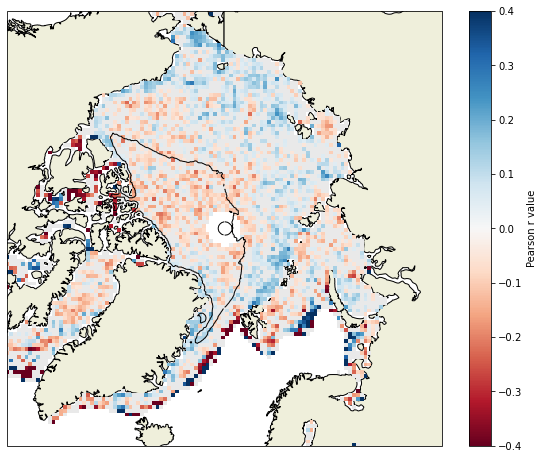

In [9]:
# Map showing gridcell-by-gridcell correlation between SM-LG and CS2_CPOM interpolated freeboards 
# smoothed anomalies for full 2010-2020 period. Grey areas are where p>0.05

lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

rs[ps>0.05] = 1000
grey = rs.copy()
grey[grey <1000] = np.nan
rs[rs==1000] = np.nan

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax.pcolormesh(lons,lats,rs,cmap='RdBu',vmin=-0.4,vmax=0.4,alpha=1.0, transform=ccrs.PlateCarree())
ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
a = fig.colorbar(p_map)
a.set_label('Pearson r value')

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

cont_less = ax.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

# plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/AGU GRL Snow Interpolated Freeboards/figures/CS2_gridcells.png',bbox_inches = "tight")

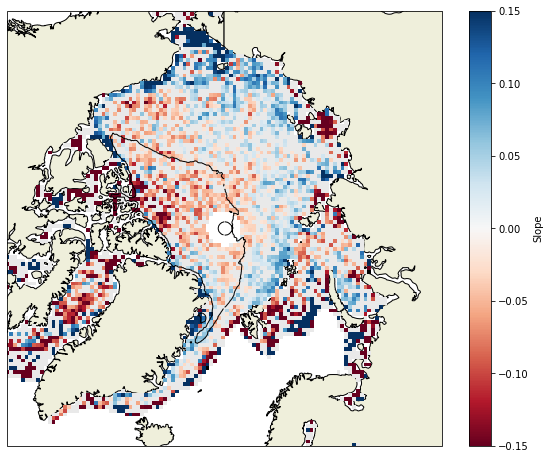

In [27]:
# Map showing gridcell-by-gridcell slope between SM-LG and CS2_CPOM interpolated freeboards 
# smoothed anomalies for full 2010-2020 period. Grey areas are where p>0.05

lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

ss[ps>0.05] = 1000
grey = ss.copy()
grey[grey <1000] = np.nan
ss[ss==1000] = np.nan

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax.pcolormesh(lons,lats,ss,cmap='RdBu',vmin=-0.15,vmax=0.15,alpha=1.0, transform=ccrs.PlateCarree())
ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
a = fig.colorbar(p_map)
a.set_label('Slope')

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

cont_less = ax.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/AGU GRL Snow Interpolated Freeboards/figures/CS2_gridcells_slope.png',bbox_inches = "tight")

## only cells where FYI >75% of the time

In [ ]:
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017',
           '2017-2018','2018-2019','2019-2020']
#seasons: 01/10 - 30/04
dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2465,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3195,3407), # 2018-2019
        np.arange(3560,3773), # 2019-2020
       ]

In [ ]:
threshp = 0.75
# pick a threshold for number of days to be FYI

total = len(dayss[0])+len(dayss[1])+len(dayss[2])+len(dayss[3])+len(dayss[4])+len(dayss[5])+len(dayss[6])+len(dayss[7])+len(dayss[8])+len(dayss[9])
thresh = total * threshp

all_FYI = {} ; all_MYI = {}
FYI_days = {} ; MYI_days = {}

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/'
for season, days in zip(seasons,dayss):
    
    icetype_grid = np.load(datapath+'icetype_'+'Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')
                 
    FYI_days[season] = (icetype_grid == 2).sum(axis = 2).astype(np.float32)
    MYI_days[season] = (icetype_grid == 3).sum(axis = 2).astype(np.float32)

all_FYI = sum(FYI_days.values())
all_MYI = sum(MYI_days.values())    
    
all_FYI[all_FYI < thresh] = np.nan  
all_FYI[~np.isnan(all_FYI)] = 1
all_MYI[all_MYI < thresh] = np.nan 
all_MYI[~np.isnan(all_MYI)] = 1

In [ ]:
# cartopy
lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

rs_fyi = rs.copy()
rs_fyi[np.isnan(all_FYI)] = np.nan

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax.pcolormesh(lons,lats,rs_fyi,cmap='RdBu',vmin=-0.2,vmax=0.2,alpha=0.6, transform=ccrs.PlateCarree())
ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
a = fig.colorbar(p_map)
a.set_label('Pearson r value')
ax.set_title('Correlation between SM-LG and CS2_CPOM interpolated freeboards smoothed anomalies for full 2010-2020 period',fontsize='x-large', pad=20)
ax.set_xlabel('Grey areas are where p>0.05')

## only cells where MYI >75% of the time

In [ ]:
# cartopy
lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

rs_myi = rs.copy()
rs_myi[np.isnan(all_MYI)] = np.nan

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax.pcolormesh(lons,lats,rs_myi,cmap='RdBu',vmin=-0.2,vmax=0.2,alpha=0.6, transform=ccrs.PlateCarree())
ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
a = fig.colorbar(p_map)
a.set_label('Pearson r value')
ax.set_title('Correlation between SM-LG and CS2_CPOM interpolated freeboards smoothed anomalies for full 2010-2020 period',fontsize='x-large', pad=20)
ax.set_xlabel('Grey areas are where p>0.05')

# plot each season separately

In [ ]:
all_rs = {}
all_ps = {}

counters = np.arange(0,len(seasons))

for season, counter, day in zip(seasons, counters, dayss):
    fb = fb_running_mean_anoms[day]
    sd = sd_running_mean_anoms[day]
    
    ps = np.full((160,160), np.nan)
    rs = np.full((160,160), np.nan)

    for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                                  np.arange(160))):
        # calculate p and r for full timeseries per grid cell

        mask = ~np.isnan(fb[:,i,j]) & ~np.isnan(sd[:,i,j]) # mask out cells with nan snow or nan freeb

        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue

            rstats = pearsonr(fb[:,i,j][mask],sd[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
            r = np.round(rstats[0],decimals=2)
            p = np.round(rstats[1],decimals=3)
            ps[i,j] = p
            rs[i,j] = r

    all_rs[counter] = rs   
    all_ps[counter] = ps 

In [ ]:
fig, axs = plt.subplots(5,2,figsize = (10,25),subplot_kw={'projection':ccrs.NorthPolarStereo()})

for counter, ax in enumerate(axs.reshape(-1)):
    season = seasons[counter]
    
    rs = all_rs[counter]
    ps = all_ps[counter]
    rs[ps>0.05] = 1000
    grey = rs.copy()
    grey[grey <1000] = np.nan
    rs[rs==1000] = np.nan            
      
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    p_map = ax.pcolormesh(lons,lats,rs,cmap='RdBu',vmin=-0.2,vmax=0.2,alpha=0.6, transform=ccrs.PlateCarree())
    ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
    ax.set_title(season)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p_map, cax=cbar_ax)


## only cells where FYI >75% of the time

In [ ]:
threshp = 0.75 # pick a threshold for fraction of days to be FYI

all_FYI = {}
all_MYI = {}

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/'
for season, days in zip(seasons,dayss):
    thresh = len(days)*threshp
    
    icetype_grid = np.load(datapath+'icetype_'+'Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')
                 
    FYI_days = (icetype_grid == 2).sum(axis = 2).astype(np.float32)
    MYI_days = (icetype_grid == 3).sum(axis = 2).astype(np.float32)
    
    FYI_days[FYI_days < thresh] = np.nan # 170 is threshold on days of FYI 
    FYI_days[~np.isnan(FYI_days)] = 1
    MYI_days[MYI_days < thresh] = np.nan # 170 is threshold on days of FYI 
    MYI_days[~np.isnan(MYI_days)] = 1
    
    all_FYI[season] = FYI_days
    all_MYI[season] = MYI_days

In [ ]:
fig, axs = plt.subplots(5,2,figsize = (10,25),subplot_kw={'projection':ccrs.NorthPolarStereo()})

for counter, ax in enumerate(axs.reshape(-1)):
    season = seasons[counter]
    fyii = all_FYI[season]
    
    rs_fyi = all_rs[counter].copy()
    rs_fyi[np.isnan(fyii)] = np.nan
    ps = all_ps[counter]         
      
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=5)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    p_map = ax.pcolormesh(lons,lats,rs_fyi,cmap='RdBu',vmin=-0.2,vmax=0.2,alpha=0.6, transform=ccrs.PlateCarree())
    ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
    ax.set_title(season)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p_map, cax=cbar_ax)

In [ ]:
## only cells where MYI >75% of the time

In [ ]:
fig, axs = plt.subplots(5,2,figsize = (10,25),subplot_kw={'projection':ccrs.NorthPolarStereo()})

for counter, ax in enumerate(axs.reshape(-1)):
    season = seasons[counter]
    myii = all_MYI[season]
    
    rs_myi = all_rs[counter].copy()
    rs_myi[np.isnan(myii)] = np.nan
    ps = all_ps[counter]           
      
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=5)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    p_map = ax.pcolormesh(lons,lats,rs_myi,cmap='RdBu',vmin=-0.2,vmax=0.2,alpha=0.6, transform=ccrs.PlateCarree())
    ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
    ax.set_title(season)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p_map, cax=cbar_ax)

In [ ]:
# to do:
    # do plot with mask out negative snow anomalies
    # do plot with first year of fb cut off and last year of snow cut off - shows random noise
    # mask for less than 500 valid cells
    # find out number of pixels with statistical significance

In [ ]:
# we love basemap

ps[ps>0.05] = np.nan
fig,ax = plt.subplots(1,figsize=(10,10))
m = Basemap(projection='npstere',boundinglat=60,lon_0=0, resolution='l',round=False)
m.fillcontinents(color='beige',alpha=0.4)
m.drawcoastlines(color='black',linewidth=0.1)
p_map = m.pcolormesh(x_WG,y_WG,n_valid,cmap='plasma')
a = m.colorbar(p_map) 
a.set_label('N valid points in regression',fontsize='x-large')
plt.title('Correlation between SM-LG and CS2_CPOM interpolated freeboards for full 2010-2021 period',fontsize='x-large', pad=20)
ax.set_xlabel('Hatching shows p<0.05')

# old code for safekeeping

In [ ]:
# old, long version of the code: takes 2.5 hours to run for full 10 years of data
'''
T1 = 15 ## for 30-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

ps = np.full((160,160), np.nan)
rs = np.full((160,160), np.nan)
        
for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                              np.arange(160))):
    
    
    
    freebs = np.full((4018), np.nan)
    snows = np.full((4018), np.nan)
    
    for day in days:

        # load snow and fb for specific cell
        snows[day] = snow[day][i,j] # create daily snow list for specific grid cell
        freebs[day] = all_fbs[day][i,j] # create daily fb list for specific grid cell
        
    if np.isnan(snows).all() or np.isnan(freebs).all():
        
        pass
    
    else:
        

        # 30-day running mean   
        freebs_30day = np.full((4018), np.nan)
        snows_30day = np.full((4018), np.nan)

        for day in days[T1:-T1]:
            freebs_30day[day] = np.nanmean(freebs[day-T1:day+T1])
            snows_30day[day] = np.nanmean(snows[day-T1:day+T1])

        # anomaly from 30-day running mean    
        freebs_anoms = np.asarray(freebs) - np.asarray(freebs_30day)
        snows_anoms = np.asarray(snows) - np.asarray(snows_30day)

        # 9-day running mean of anomalies
        freebs_smooth_anoms = np.full((4018), np.nan)
        snows_smooth_anoms = np.full((4018), np.nan) 

        for day in days[T1+T2:-T1+T2]: 
            freebs_smooth_anoms[day] = np.nanmean(freebs_anoms[day-T2:day+T2])
            snows_smooth_anoms[day] = np.nanmean(snows_anoms[day-T2:day+T2])

        # calculate p and r for full timeseries per grid cell
        if np.count_nonzero(np.nan_to_num(mask)) > 2:

            rstats = pearsonr(freebs_smooth_anoms[mask],snows_smooth_anoms[mask])
            r = np.round(rstats[0],decimals=2)
            p = np.round(rstats[1],decimals=3)
            ps[i,j] = p
            rs[i,j] = r
'''